---
The base for that code below was the notebook: 
## **»How to make a racist AI without really trying«**

A cautionary tutorial by Robyn Speer, 2017, see: https://gist.github.com/rspeer/ef750e7e407e04894cb3b78a82d66aed

The comments have been translated and adapted for our purposes - The code has been taken over like this except for a few changes.

see also: http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/

---

Rob Speer, co-founder of Luminoso, published an article on how the Common Crawl data can lead to racist behavior. He illustrates it by using sentiment classification, a common task in Natural Language Processing that aims to assign positive or negative sentiments to words and sentences. Given a list of positive and negative words, he trains an artificial agent that learns to classify sentences into these two categories.

The results reveal some unfortunate truths: the sentence “Let’s go get Italian food” is classified as more positive than “Let’s go get Mexican food”, even though they are functionally the same.  A more horrifying bias exists for names, where a seemingly neutral sentence “My name is Emily” is classified as positive, while “My name is Shaniqua” is classified as negative. As he points out, the more stereotypically white a name is, the more positive its sentiment.


---

# UPDATE 
# <u>!!!We can not use that code anymore because we are not able to downgrade pandas as down as neeadable!!!!</u>

---

## Creating a Sentiment-Classifier
...as an example of a well-known way to use word embeddings
Outline:
* Incorporate some common word embeddings to represent the meaning of words.
* Collect training and test data with gold-standard examples of positive and negative words.
* Train a classifier using gradient descent to recognize other positive and negative words based on their word embeddings.
* Calculate (using this classifier) sentiment scores for text sentences
* Evalutation
---
* Einbinden einiger gängiger Worteinbettungen , um die Bedeutung von Wörtern darzustellen
* Erfassen der Trainings- und Testdaten mit gold-standard Beispielen für positive und negative Wörter
* Trainieren einen Klassifikators mithilfe des Gradientenabstiegs, um andere positive und negative Wörter anhand ihrer Worteinbettungen zu erkennen
* Berechnen (mit diesem Klassifikator) der Stimmungswerte für Textsätze
* Evalutation

## Step 0: import librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn
import re
import statsmodels.formula.api

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# Configure how graphs will show up in this notebook
%matplotlib inline
seaborn.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)

## Step 1: Word embeddings

Word embeddings are frequently used to represent words as inputs to machine learning. The words become vectors in a multi-dimensional space, where nearby vectors represent similar meanings. With word embeddings, you can compare words by (roughly) what they mean, not just exact string matches.

Successfully training word vectors requires starting from hundreds of gigabytes of input text. Fortunately, various machine-learning groups have already done this and provided pre-trained word embeddings that we can download.

Two very well-known datasets of pre-trained English word embeddings are **word2vec**, pretrained on Google News data, and **GloVe**, pretrained on the Common Crawl of web pages. We would get similar results for either one, but here we'll use GloVe because its source of data is more transparent.

GloVe comes in three sizes: 6B, 42B, and 840B. The 840B size is powerful, but requires significant post-processing to use it in a way that's an improvement over 42B. The 42B version is pretty good and is also neatly trimmed to a vocabulary of 1 million words. Because we're following the path of least resistance, we'll just use the 42B version.

> **Why does it matter that the word embeddings are "well-known"?**
>
> I'm glad you asked, hypothetical questioner! We're trying to do something extremely typical at each step, and for some reason, comparison-shopping for better word embeddings isn't typical yet. Read on, and I hope you'll come out of this tutorial with the desire to use [modern, high-quality word embeddings](https://github.com/commonsense/conceptnet-numberbatch), especially those that are aware of algorithmic bias and try to mitigate it. But that's getting ahead of things.

We download glove.42B.300d.zip from [the GloVe web page](https://nlp.stanford.edu/projects/glove/), and extract it into `data/glove.42B.300d.txt`. Next we define a function to read the simple format of its word vectors.


In [3]:
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('data/glove.42B.300d.txt')
embeddings.shape

(1917494, 300)

## Step 2: A gold-standard sentiment lexicon

We need some input about which words are positive and which words are negative. There are many sentiment lexicons you could use, but we're going to go with a very straightforward lexicon (Hu and Liu, 2004), the same one used by the Deep Averaging Networks paper.

We download the lexicon from Bing Liu's web site (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon) and extract it into `data/positive-words.txt` and `data/negative-words.txt`.

Next we define how to read these files, and read them in as the `pos_words` and `neg_words` variables:

In [4]:
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon('data/positive-words.txt')
neg_words = load_lexicon('data/negative-words.txt')

## Step 3: Train a model to predict word sentiments

Our data points here are the embeddings of these positive and negative words. We use the Pandas `.loc[]` operation to look up the embeddings of all the words.

Some of these words are not in the GloVe vocabulary, particularly the misspellings such as "fancinating". Those words end up with rows full of `NaN` to indicate their missing embeddings, so we use `.dropna()` to remove them.

In [5]:
pos_vectors = embeddings.loc[pos_words].dropna()
neg_vectors = embeddings.loc[neg_words].dropna()

Now we make arrays of the desired inputs and outputs. The inputs are the embeddings, and the outputs are 1 for positive words and -1 for negative words. We also make sure to keep track of the words they're labeled with, so we can interpret the results.

In [6]:
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

Using the scikit-learn `train_test_split` function, we simultaneously separate the input vectors, output values, and labels into training and test data, with 10% of the data used for testing.

In [7]:
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

Now we make our classifier, and train it by running the training vectors through it for 100 iterations. We use a logistic function as the loss, so that the resulting classifier can output the probability that a word is positive or negative.

In [8]:
model = SGDClassifier(loss='log', random_state=0, n_iter=100)
model.fit(train_vectors, train_targets)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=100, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False)

We evaluate the classifier on the test vectors. It predicts the correct sentiment for sentiment words outside of its training data 95% of the time. Not bad.

Wir bewerten den Klassifikator anhand der Testvektoren. 

In 95% der Fälle wird die korrekte Stimmung für Stimmungswörter außerhalb der Trainingsdaten vorhergesagt:

In [9]:
accuracy_score(model.predict(test_vectors), test_targets)

0.95022624434389136

Let's define a function that we can use to see the sentiment that this classifier predicts for particular words, then use it to see some examples of its predictions on the test data.

Wir definieren wir eine Funktion, mit der wir die Stimmung sehen können, die dieser Klassifikator für bestimmte Wörter vorhersagt, und verwenden sie dann, um einige Beispiele seiner Vorhersagen in den Testdaten zu sehen.

In [10]:
def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)


# Show 20 examples from the test set
words_to_sentiment(test_labels).ix[:20]

,sentiment
fidget,-9.931679
interrupt,-9.634706
staunchly,1.466919
imaginary,-2.989215
taxing,0.468522
world-famous,6.908561
low-cost,9.237223
disapointment,-8.737182
totalitarian,-10.851580
bellicose,-8.328674


More than the accuracy number, this convinces us that the classifier is working. We can see that the classifier has learned to generalize sentiment to words outside of its training data.

Dies zeigt, dass der Klassifikator funktioniert. Wir können sehen, dass der Klassifikator gelernt hat, die Stimmung auf Wörter außerhalb seiner Trainingsdaten zu verallgemeinern.

## Step 4: Get a sentiment score for text

There are many ways to combine sentiments for word vectors into an overall sentiment score. Again, because we're following the path of least resistance, we're just going to average them.

In [11]:
import re
TOKEN_RE = re.compile(r"\w.*?\b")
# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.


def text_to_sentiment(text):
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    sentiments = words_to_sentiment(tokens)
    return sentiments['sentiment'].mean()

There are many things we could have done better:

- Weight words by their inverse frequency, so that words like "the" and "I" don't cause big changes in sentiment
- Adjust the averaging so that short sentences don't end up with the most extreme sentiment values
- Take phrases into account
- Use a more robust word-segmentation algorithm that isn't confused by apostrophes
- Account for negations such as "not happy"

But all of those would require extra code and wouldn't fundamentally change the results we're about to see. At least now we can roughly compare the relative positivity of different sentences:

In [12]:
text_to_sentiment("this example is pretty cool")

3.889968926086298

In [13]:
text_to_sentiment("this example is okay")

2.7997773492425186

In [14]:
text_to_sentiment("meh, this example sucks")

-1.1774475917460698

## Step 5: Behold the monstrosity that we have created

Not every sentence is going to contain obvious sentiment words. Let's see what it does with a few variations on a neutral sentence:

Nicht jeder Satz wird offensichtliche Stimmungswörter enthalten. Mal sehen, was es mit ein paar Variationen eines neutralen Satzes macht:

In [15]:
text_to_sentiment("Let's go get Italian food")

2.0429166109408983

In [16]:
text_to_sentiment("Let's go get Chinese food")

1.4094033658140972

In [17]:
text_to_sentiment("Let's go get Mexican food")

0.38801985560121732

This is analogous to what I saw when I experimented with analyzing restaurant reviews using word embeddings, and found out that [all the Mexican restaurants were ending up with lower sentiment](https://blog.conceptnet.io/2017/04/24/conceptnet-numberbatch-17-04-better-less-stereotyped-word-vectors/) for no good reason.

Word vectors are capable of representing subtle distinctions of meaning just by reading words in context. So they're also capable of representing less-subtle things like the biases of our society.

Here are some other neutral statements:

In [18]:
text_to_sentiment("My name is Emily")

2.2286179364745311

In [19]:
text_to_sentiment("My name is Heather")

1.3976291151079159

In [20]:
text_to_sentiment("My name is Yvette")

0.98463802132985556

In [21]:
text_to_sentiment("My name is Shaniqua")

-0.47048131775890656

Well, dang.

The system has associated wildly different sentiments with people's names. You can look at these examples and many others and see that the sentiment is generally more positive for stereotypically-white names, and more negative for stereotypically-black names.

This is the test that Caliskan, Bryson, and Narayanan used to conclude that [semantics derived automatically from language corpora contain human-like biases](http://opus.bath.ac.uk/55288/), a paper published in *Science* in April 2017, and we'll be using more of it shortly.

Das System hat den Namen der Menschen völlig unterschiedliche Gefühle zugeordnet. 

Wir könnwn viele weitere ähnliche Beispiele ansehen und feststellen, dass die Stimmung für stereotypisch weiße Namen im Allgemeinen positiver und für stereotypisch schwarze Namen negativer ist.

Dies ist der Test, den Caliskan, Bryson und Narayanan verwendet haben, um zu dem Schluss zu kommen, dass [Semantik, die automatisch von Sprachkorpora abgeleitet wird, menschenähnliche Verzerrungen enthält](http://opus.bath.ac.uk/55288/), ein Artikel, der im April 2017 in Science veröffentlicht wurde.

## Step 6: Measure the problem

We want to learn how to not make something like this again. So let's put more data through it, and statistically measure how bad its bias is.

Here we have four lists of names that tend to reflect different ethnic backgrounds, mostly from a United States perspective. The first two are lists of predominantly "white" and "black" names adapted from Caliskan et al.'s article. I also added typically Hispanic names, as well as Muslim names that come from Arabic or Urdu; these are two more distinct groupings of given names that tend to represent your background.

This data is currently used as a bias-check in the ConceptNet build process, and can be found in the `conceptnet5.vectors.evaluation.bias` module. I'm interested in expanding this to more ethnic backgrounds, which may require looking at surnames and not just given names.

Here are the lists:

Hier haben wir vier Listen mit Namen, die unterschiedliche ethnische Hintergründe widerspiegeln, hauptsächlich aus Sicht der Vereinigten Staaten. Die ersten beiden sind Listen mit überwiegend „weißen“ und „schwarzen“ Namen, die aus dem Artikel von Caliskan et al. Angepasst wurden. Ich habe auch typisch spanische Namen sowie muslimische Namen hinzugefügt, die aus dem Arabischen oder Urdu stammen. Dies sind zwei weitere unterschiedliche Gruppierungen von Vornamen, die dazu neigen, Ihren Hintergrund darzustellen.

Diese Daten werden derzeit als Bias-Check im ConceptNet-Erstellungsprozess verwendet und befinden sich im `conceptnet5.vectors.evaluation.bias` Modul. 

Hier sind die Listen:

In [22]:
NAMES_BY_ETHNICITY = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],
    
    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    
    # The following list conflates religion and ethnicity, I'm aware. So do given names.
    #
    # This list was cobbled together from searching baby-name sites for common Muslim names,
    # as spelled in English. I did not ultimately distinguish whether the origin of the name
    # is Arabic or Urdu or another language.
    #
    # I'd be happy to replace it with something more authoritative, given a source.
    'Arab/Muslim': [
        'Mohammed', 'Omar', 'Ahmed', 'Ali', 'Youssef', 'Abdullah', 'Yasin', 'Hamza',
        'Ayaan', 'Syed', 'Rishaan', 'Samar', 'Ahmad', 'Zikri', 'Rayyan', 'Mariam',
        'Jana', 'Malak', 'Salma', 'Nour', 'Lian', 'Fatima', 'Ayesha', 'Zahra', 'Sana',
        'Zara', 'Alya', 'Shaista', 'Zoya', 'Yasmin'
    ]
}

Now we'll use Pandas to make a table of these names, their predominant ethnic background, and the sentiment score we get for them:

Jetzt benutzen wir `Pandas` um eine Tabelle dieser Namen zu erstellen mit ihrem jeweilgen vorherrschenden ethnischen Background und dem ''sentiment score'' dafür:

In [23]:
def name_sentiment_table():
    frames = []
    for group, name_list in sorted(NAMES_BY_ETHNICITY.items()):
        lower_names = [name.lower() for name in name_list]
        sentiments = words_to_sentiment(lower_names)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

name_sentiments = name_sentiment_table()

A sample of the data:

In [24]:
name_sentiments.ix[::25]

,sentiment,group
mohammed,0.834974,Arab/Muslim
alya,3.916803,Arab/Muslim
terryl,-2.858010,Black
josé,0.432956,Hispanic
luciana,1.086073,Hispanic
hank,0.391858,White
megan,2.158679,White


Now we can visualize the distribution of sentiment we get for each kind of name:

(-10, 10)

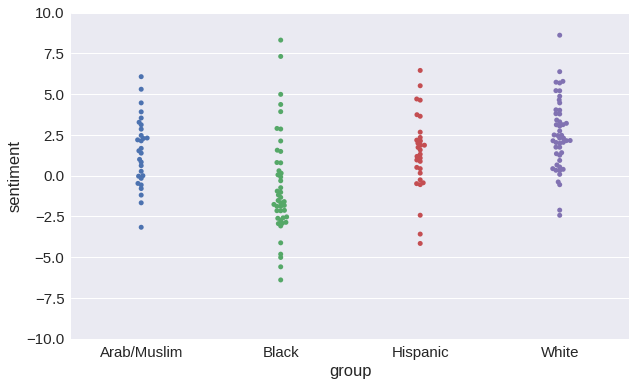

In [25]:
plot = seaborn.swarmplot(x='group', y='sentiment', data=name_sentiments)
plot.set_ylim([-10, 10])

Each and every dot in the above graph represents how positive a name that stereotypically belongs to that group is. We can see that names in the white group are, on average, perceived as more positive. Even if your chatbot does not specifically calculate the sentiment of your sentences, the underlying patterns that cause this issue are still in your data.

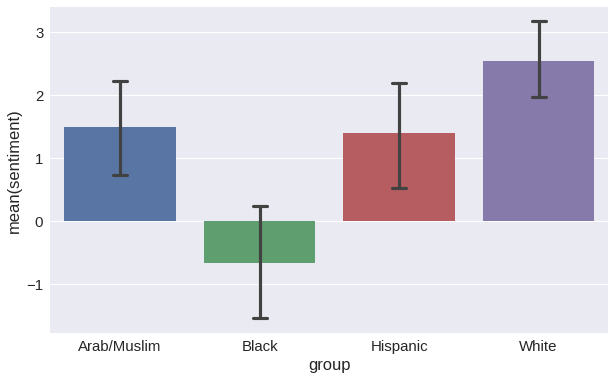

In [26]:
plot = seaborn.barplot(x='group', y='sentiment', data=name_sentiments, capsize=.1)